<a href="https://colab.research.google.com/github/Antony-gitau/probabilistic_AI_playgraound/blob/main/Introduction_to_Pyro_modelling_language_and_inference_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a collection of examples and notes of my pursuit to understand how to model probablistic machine learning algorithmns using a python based language --pyro.

terms:
- Pyro is a probablistic programming language (PPL) based on python and pytorch. 

- probabilistic machine learning algorithmms - models that are built in the language of probability.

- probability is the mathematics of reasoning under uncertainity. 

- probabilistic program - a mixture of deterministic computation and randomly sampled values. 

- A latent variable is one that cannot be directly observed but is estimated based on a series of observed variables. In pyro, these variables are graphically represented as unshaded nodes.

- Inference is drawing conclusions about latent variable from the data.

- prior probability - it is the probability before evidence is taken into account.

- posterior distribution is the result of updating the likelihood infomation (or evidence) to prior probability.



In [1]:
%%capture
!pip install -q --upgrade pyro-ppl torch
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

We got this data from the [pyro documenatation page](https://pyro.ai/examples/intro_long.html#).

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

# we only want to investigate the ruggedness index, GPD per capital 
#of countries in Africa or not
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [3]:
df.head()

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113


We are filtering out the rows under column `rgdppc_2000`that are non-finite, meaning they are NaN or infinity.

We make these changes to our dataframe which results into columns with only finite values.

In [4]:
df =df[np.isfinite(df['rgdppc_2000'])]
df.head(10)

,cont_africa,rugged,rgdppc_2000
2,1,0.858,1794.729
4,0,3.427,3703.113
7,0,0.769,20604.460
8,0,0.775,12173.680
9,0,2.688,2421.985
11,0,0.006,10022.030
12,0,0.143,25417.440
13,0,3.513,28987.840
14,0,1.672,2570.944
15,1,1.780,621.652


We then convert the finite values in the `rgdppc_2000` to natural log. We do so normalize the data or reduce the influence of extreme values ( [Best practice in statistics: The use of log transformation article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9036143/).

In [5]:
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df.head(10)

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
11,0,0.006,9.212541
12,0,0.143,10.143191
13,0,3.513,10.274632
14,0,1.672,7.852028
15,1,1.780,6.432380


In [6]:
values = df.values
print(values.shape)
print(values.dtype)

(170, 3)
float64


We want to convert the numpy arrays above in the dataframe, df to torch tensors for processing in pytorch and pyro.

To do that, we first get all the numpy array ,`df.values`, and pass them through the ,`torch.tensor function`, as we specify the type of torch tensors as floating points. 

We then assign the three variables (columns) the appropriate tensors.

In [7]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [8]:
train.shape

torch.Size([170, 3])

Let's try to visualize our data.

1. A scatter plot of african nation rugged index on x axis and their GDPs on the y axis.

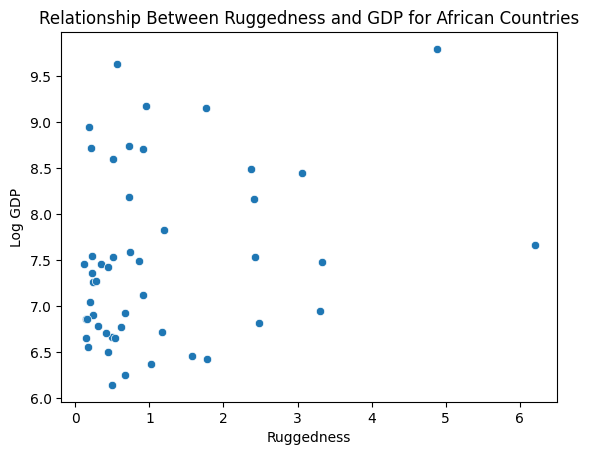

In [9]:
# Create a subset of the original dataframe containing only African countries
african_countries = df[df['cont_africa'] == 1]

# Create a scatter plot of ruggedness vs. log GDP for African countries
sns.scatterplot( x = african_countries['rugged'],
                y = african_countries['rgdppc_2000'])


# Set the plot title and axis labels
plt.title('Relationship Between Ruggedness and GDP for African Countries')
plt.xlabel('Ruggedness')
plt.ylabel('Log GDP')

# Display the plot
plt.show()

2. We can use the above code (only changing the countries to non-african) to plot for non- african countries as well.

Text(0, 0.5, 'Log GDP')

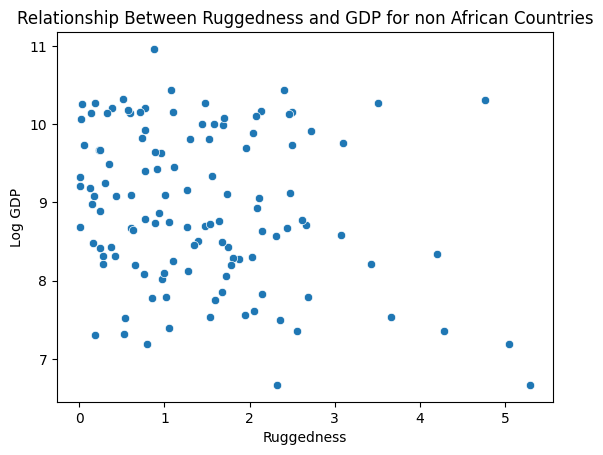

In [10]:
# Create a subset of the original dataframe containing only African countries
non_african_countries = df[df['cont_africa'] == 0]

# Create a scatter plot of ruggedness vs. log GDP for African countries
sns.scatterplot( x = non_african_countries['rugged'],
                y = non_african_countries['rgdppc_2000'])


# Set the plot title and axis labels
plt.title('Relationship Between Ruggedness and GDP for non African Countries')
plt.xlabel('Ruggedness')
plt.ylabel('Log GDP')

# Display the plot

The two plot show that there is a possibile relationship between the ruggedness and GDP.

We can be certain by employing bayesian linear regression.

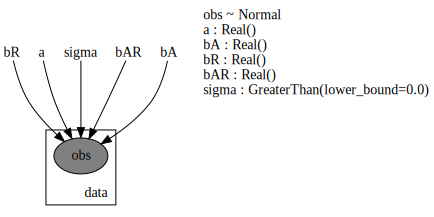

In [11]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# we create a pyro model and pass three variables with log_gdp as none as its the dependent variable
def simple_model(is_cont_africa, ruggedness, log_gdp=None):

  # we define model parameters as pyro parameters which could be learned by inference
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)


    #  mean of the normal distribution that describes the relationship dependent and independent variable
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

# calculate the posterior distribution over the model parameters given the observed data
    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

#generates a graphical representation of the model
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)


In the above code;
1. we import the pyro libraries that we need for distribution and constraints definition

2. we define a model function that will take in the three variable -- 2 independent (is_cont_africa and ruggedness) and one dependent (log_gdp)

3. We initialize model parameters as pyro learnable parameters that could be learned through probabilistic inference. 

4. we define the multiple regression predictor function that will calculate the normal distribution that describes the relationship between the predictors (independent)and reponse (or dependent) variable in this case log GDP. 

5. We lastly  calculate the posterior distribution over the model parameters given the observed data and render them as graphical representation.

**Variational inference:**
 this is one of the approximate inference algorithms.

This is how it works:
 - Finds the real-valued parameters( $\theta_{max}$) of distribution $𝑞_𝜙(z)$ 
 - Compute the approximation of parameterized distribution $𝑞_𝜙(z)$ to true unknown posterior $𝑃𝜃_{max}(z|x)$. $𝜙$ is variational parameter.
 - To get the approximations, convert the intergrals into optimization of functions $𝘗$ and $𝑞$.
 
  mean-field approximation -> approximate the posterior distribution over the parameters of a model,

In [17]:
# we define a guide function that takes same parameters as the model above
#guide function the variational distribution
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):

  # we define and initialize the pyro parameters used by the guide. 
  a_loc = pyro.param("a_loc", lambda: torch.tensor(0.))
  a_scale = pyro.param("a_scale", lambda: torch.tensor(1.), constraint=constraints.positive)
  sigma_loc = pyro.param("sigma_loc", lambda: torch.tensor(1.), constraint=constraints.positive)

  weights_loc = pyro.param("weights_loc", lambda:torch.randn(3))
  weights_scale = pyro.param("weights_scale", lambda:torch.ones(3), constraint=constraints.positive)
  
  a = pyro.sample("a", dist.Normal(a_loc, a_scale))
  b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
  b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
  b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
  sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
  return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}


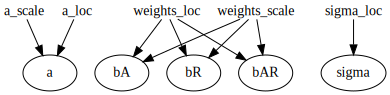

In [19]:
#visualize that random variables
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness,log_gdp), render_params=True)

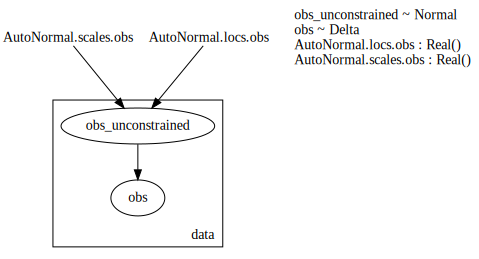

In [25]:
#generating an autoguide
auto_guide = pyro.infer.autoguide.AutoNormal(simple_model)
pyro.render_model(auto_guide, model_args=(is_cont_africa, ruggedness), render_distributions=True, render_params=True)

**Optimization:** evidence lower bound (ELBO)

ELBO = $Ε_{𝑞_𝜙(z)}[logp_𝜃(x,z) - logq_𝜙(z)]$

$logp_𝜃(x,z)$ this is the log of the functional of a model

$logq_𝜙(z)$ and this is of a guide (variational distribution).

the goal is to compute all the probabilities in the expectation of the log difference of the model and the guide.

Optimizing the ELBO is by use of stochastic gradient descent using the gradient estimates using stochastic variational inference (SVI)


In [35]:
def model():
    pyro.sample("z_1", ...)

In [36]:
def guide():
    pyro.sample("z_1", ...)

In [37]:
auto_guide2 = pyro.infer.autoguide.AutoNormal(model)

In [38]:
adam  = pyro.optim.Adam({"lr":0.02})

#optimize the output
elbo = pyro.infer.Trace_ELBO()

svi = pyro.infer.SVI(model, auto_guide2, adam, elbo)

In [39]:
import logging
import os
smoke_test = ('CI' in os.environ)